In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!pip install pymatreader
!pip install python-picard

import mne
import pymatreader
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mne.decoding import Scaler,Vectorizer, PSDEstimator, FilterEstimator
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

import sklearn.multioutput as MOR
from sklearn import svm
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, accuracy_score
from mne.decoding import Vectorizer

import os
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 12.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# %matplotlib widget
# %matplotlib qt
%matplotlib inline

In [ ]:
# Import files from mydata
X_data=np.zeros([9,95,14,512])
y_data=np.zeros([9,95,3])

for participant in range(9):
  path='/content/drive/My Drive/Dissertation/MYDATA_NEW/s0'+str(participant+1)+'/'
  X=pd.read_csv(path+'data_s0'+str(participant+1)+'.csv')
  X=X.iloc[:,1:]
  X=X.to_numpy()
  for epoch in range(95):
    X_data[participant][epoch]=np.transpose(X[512*epoch:512*(epoch+1)])

  y=pd.read_csv(path+'labels_s0'+str(participant+1)+'.csv')
  y=y.iloc[:,1:]
  y=y.to_numpy()
  y_data[participant]=y

path_00='/content/drive/My Drive/Dissertation/MYDATA_NEW/s00/'

X_00_data=np.zeros([94,14,512])
X_00=pd.read_csv(path_00+'data_s00.csv')
X_00=X_00.iloc[:,1:]
X_00=X_00.to_numpy()
for epoch in range(94):
  X_00_data[epoch]=np.transpose(X_00[512*epoch:512*(epoch+1)])

y_00=pd.read_csv(path_00+'labels_s00.csv')
y_00=y_00.iloc[:,1:]
y_00=y_00.to_numpy()
X_data.shape


(9, 95, 14, 512)

In [ ]:
# DATA NORMALIZATION
for participant in range(9):
  mu=np.mean(X_data[participant],axis=0)
  std=np.std(X_data[participant],axis=0,ddof=1)
  for epoch in range(95):
    X_data[participant][epoch]=(X_data[participant][epoch]-mu)/std
X_data.shape

(9, 95, 14, 512)

In [ ]:
# LISTS
lst=[]
for channel in range(14):
  lst2=[]
  for epoch in range(95):
    for sample in range(512):
      lst2.append(X_data[0][epoch][channel][sample])
  lst.append(lst2)
X=np.array(lst)
X.shape

(14, 48640)

Creating RawArray with float64 data, n_channels=14, n_times=48640
    Range : 0 ... 48639 =      0.000 ...   379.992 secs
Ready.
Not setting metadata
95 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 95 events and 769 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 14 dim * 2.7e+08  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 72286
[done]


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


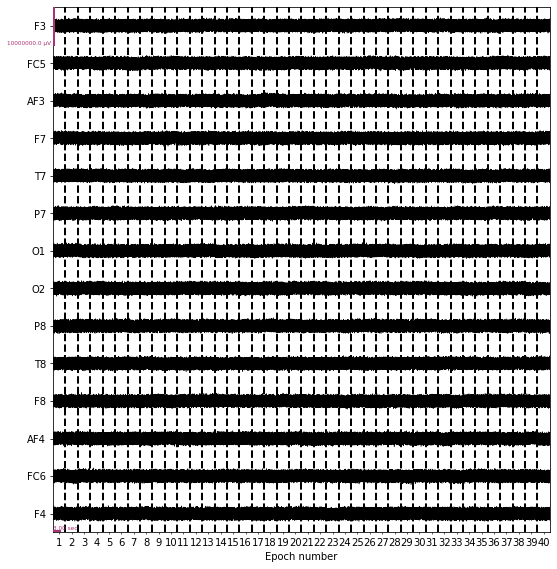

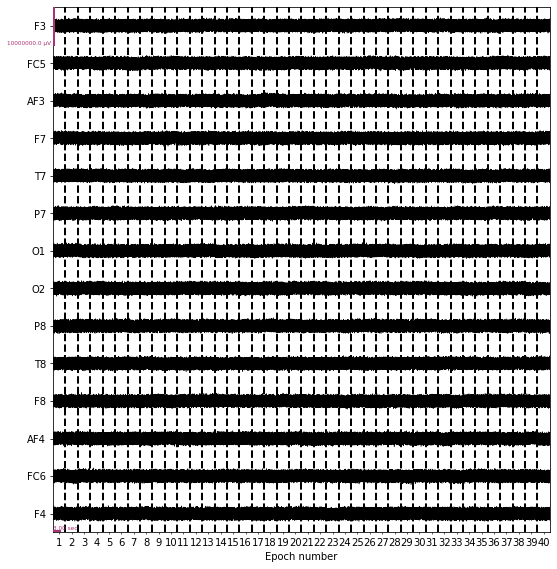

In [ ]:
# SIGNAL PROCESSING
channels=['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
sigs=['ecg', 'bio', 'stim', 'eog', 'misc', 'seeg', 'dbs', 'ecog', 'mag','eeg','ref_meg', 'grad', 'emg', 'hbr','hbo']
info=mne.create_info(ch_names=channels,sfreq=128,ch_types='eeg')

scalings=dict(mag=1e-12, grad=4e-11, eeg=5e0, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)

montage_1020 = mne.channels.make_standard_montage('standard_1020')
# epochs=mne.EpochsArray(X_data[0],info)
raw=mne.io.RawArray(X,info)
raw.set_montage(montage_1020)

events=mne.make_fixed_length_events(raw,id=1,start=-2,duration=4)
epochs=mne.Epochs(raw,events,tmin=-2,tmax=4,preload=True)
cov=mne.compute_covariance(epochs)

eeg_channels = mne.pick_types(epochs.info, eeg=True,emg=True,ecg=True,eog=True)

epochs.plot(scalings=scalings,order=eeg_channels,n_channels=14,n_epochs=40,show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows


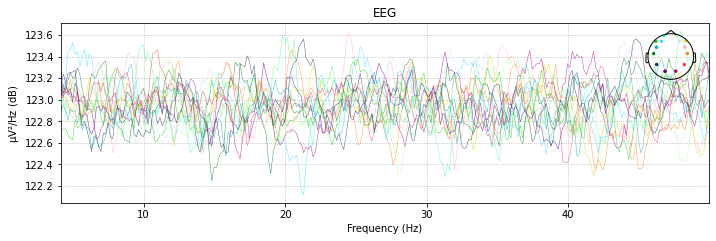

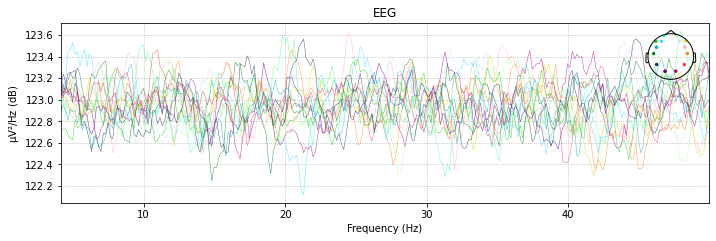

In [ ]:
epochs.plot_psd(picks=eeg_channels,fmin=4,fmax=50,average=False,spatial_colors=True)

In [ ]:
#artifact detection
ssp_projectors = epochs.info['projs']
epochs.del_proj()

Number of events,94
Events,1: 94
Time range,-2.000 – 4.000 sec
Baseline,-2.000 – 0.000 sec


Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


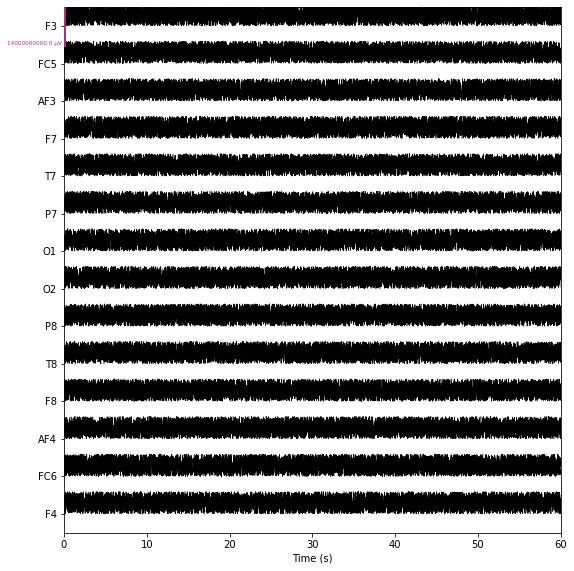

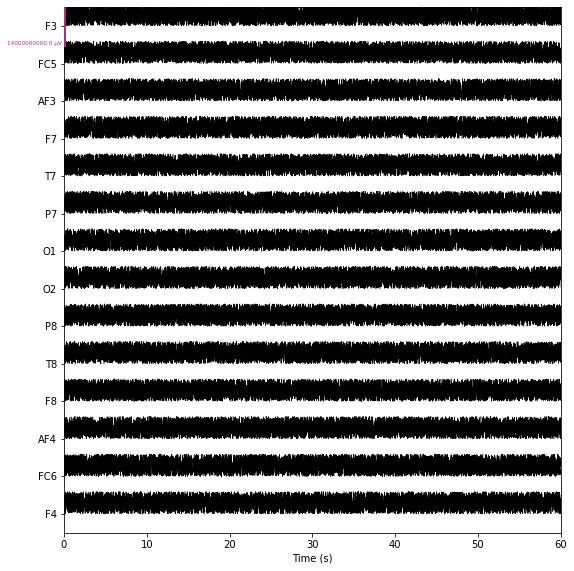

In [ ]:
#low-frequency drifts (slow drifts)
scalings=dict(mag=1e-12, grad=4e-11, eeg=70e2, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)

raw.plot(scalings=scalings,duration=60,order=eeg_channels,n_channels=14,show_scrollbars=False,remove_dc=False,proj=False)

In [ ]:
#applying the band-pass filter
filt_raw = epochs.copy().filter(l_freq=4, h_freq=50,picks=eeg_channels)
# events=mne.make_fixed_length_events(filt_raw,id=1,start=-2,duration=63)
# epochs=mne.Epochs(filt_raw,events,preload=True)

# epochs.plot(scalings='auto',picks=eeg_channels,n_channels=32)
# epochs

Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1316 out of 1316 | elapsed:    0.5s finished


In [ ]:
#ICA
ica = ICA(n_components=14,noise_cov=cov,method='fastica',max_iter='auto',random_state=97)
ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 14 dim * 1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)


<ipython-input-38-b5d2b77fc871>:3: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
<ipython-input-38-b5d2b77fc871>:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 1.5s.


Method,fastica
Fit,5 iterations on epochs (72286 samples)
ICA components,14
Explained variance,100.0 %
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


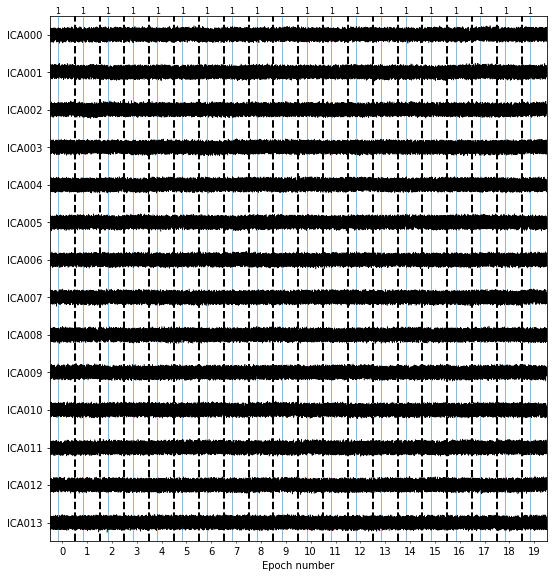

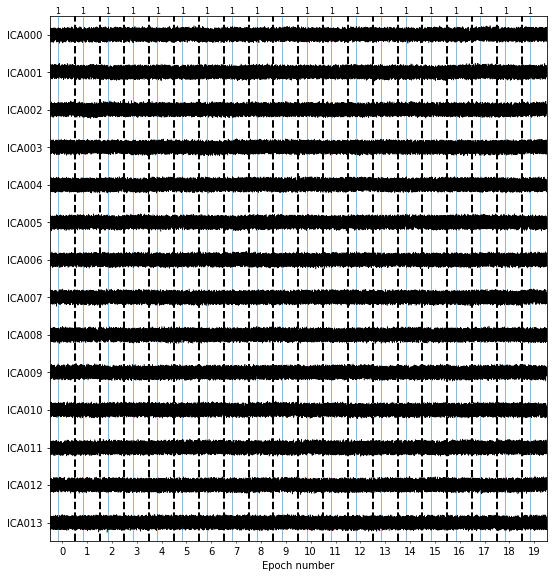

In [ ]:
ica.plot_sources(epochs,picks=eeg_channels, show_scrollbars=False)

In [ ]:
ica.plot_properties(epochs,picks=eeg_channels,dB=True,plot_std=True)

Output hidden; open in https://colab.research.google.com to view.

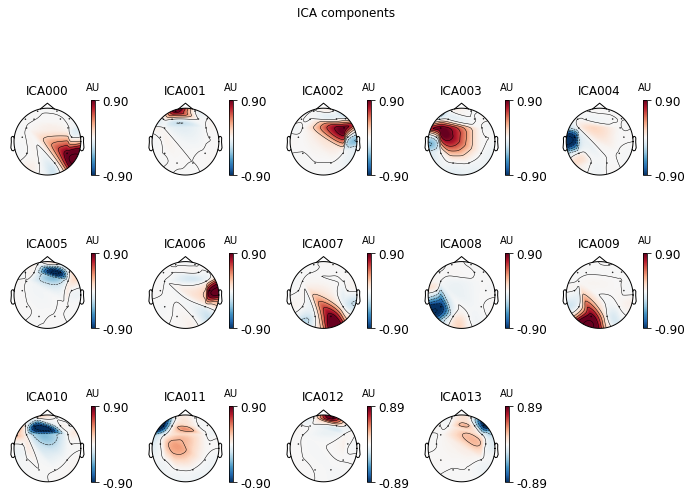

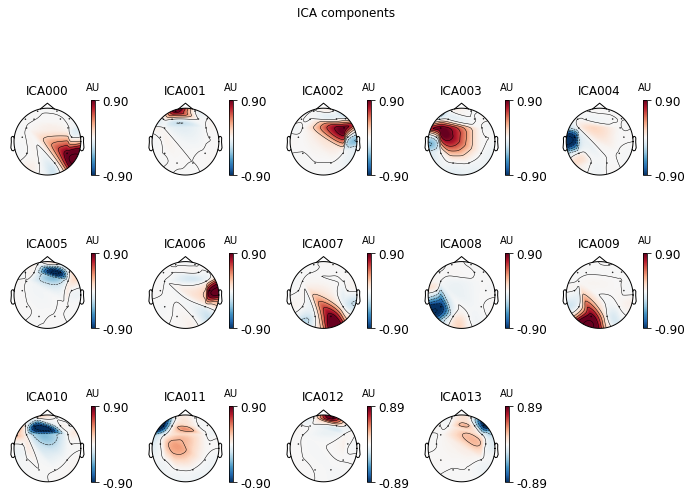

In [ ]:
ica.plot_components(picks=eeg_channels,colorbar=True)

Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


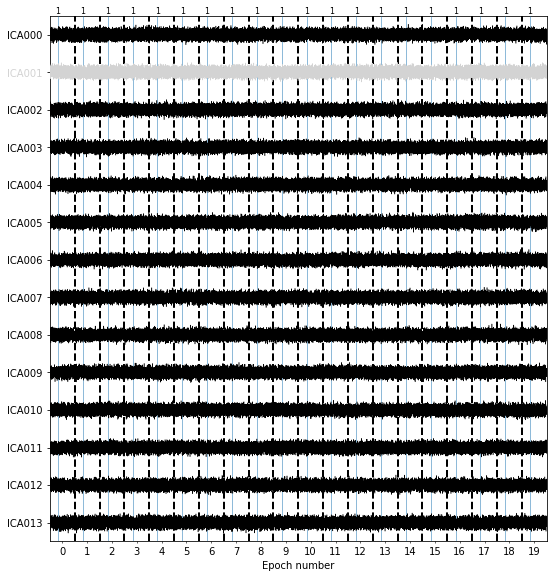

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 13 ICA components
    Projecting back using 14 PCA components


<ipython-input-42-f8952d49b7e8>:17: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(reconst_raw,ica.exclude)
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


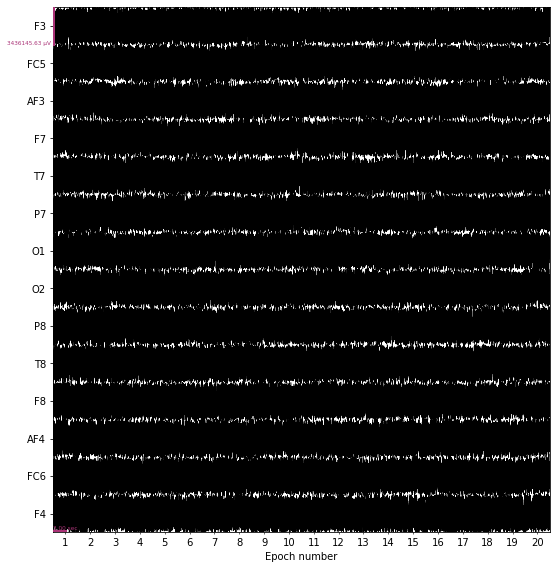

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


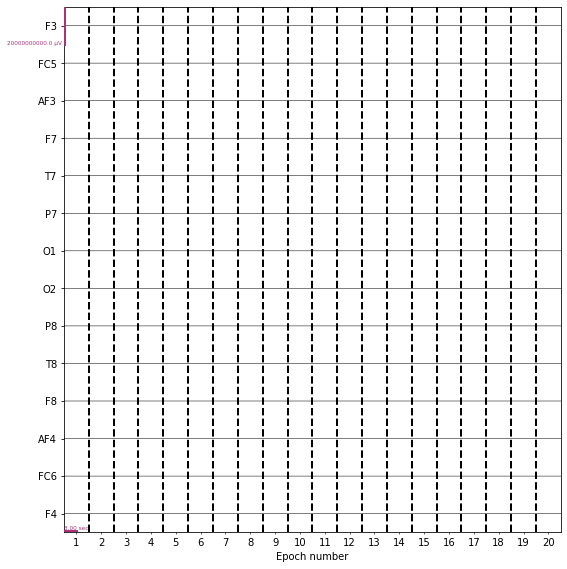

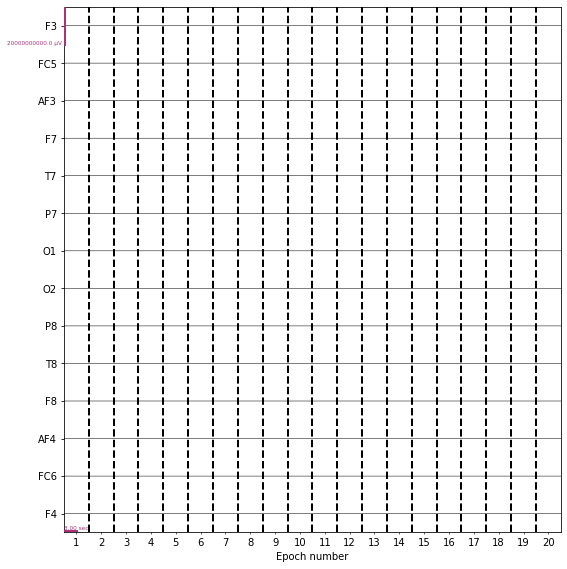

In [ ]:
#selecting components to be excluded
ica.exclude = [1]

scalings=dict(mag=1e-12, grad=4e-11, eeg=10e3, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)
_scalings=dict(mag=1e-12, grad=4e-11, eeg=10e3, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(filt_raw, picks=eeg_channels, show_scrollbars=False)


#applying ica
reconst_raw = filt_raw.copy()
ica.apply(reconst_raw,ica.exclude)

epochs.plot(scalings='auto',order=eeg_channels,n_channels=14,show_scrollbars=False)

reconst_raw.plot(scalings=_scalings,order=eeg_channels,n_channels=14,show_scrollbars=False)
